# GFER with antibodies analysis
_Maydan Wienreb_
<img src="https://raw.githubusercontent.com/maydanw/InEasyReach/master/hr-brian-litzinger-one.png" alt="Drawing" style="width: 100%; height: 60px" />

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

<div class="alert alert-warning" role="alert">
  Please note this data was extracted at 20/11/2018. Since then segmentation was improved. 
</div>

# Imports


In [12]:
"""
This will enable completion on elements of lists, results of function calls, etc.
However, be warned that enabling this option can be unsafe, because the code is actually evaluated upon hitting TAB
"""
%config IPCompleter.greedy=True

from typing import Dict, Tuple, List

# import numpy
import numpy as np
np.random.seed(0) # Remmeber to reset the seed every time if you expect the second draw to be the same as the first.

#import pandas
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# import graphics
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = [12.0, 8.0]
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns
sns.set_style("whitegrid")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# %load_ext autoreload
# %autoreload 1
# %aimport TestFunctions
## See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html


In [13]:
import os, sys
segmenter_path = "C:/Code/CellDoctor/"
sys.path.append(segmenter_path) 

from Segmenter import FolderLoader

In [14]:
import types
import sys
print ("Basic packages versions:")
print ("   Python version: %s" % (sys.version))
print ("   Packages:")


try:  
    g=globals().values()
    for i, mod in enumerate(g):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__') and hasattr(mod, '__version__'):
                print ("   %s: %s" % (mod.__name__, mod.__version__))
except: 
    g=globals().values()
    for i, mod in enumerate(g):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__') and hasattr(mod, '__version__'):
                print ("   %s: %s" % (mod.__name__, mod.__version__))

Basic packages versions:
   Python version: 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
   Packages:
   json: 2.0.9
   numpy: 1.15.0
   pandas: 0.23.3
   seaborn: 0.9.0


# General

In [15]:
patients = {"AV": {'age': 6*4, "gender": "M", "color": "cornflowerblue"}, 
            "EV": {"age": 5.5*12*4, "gender": "F", "color": "violet"},
            "HC CM": {"age": 6*12*4, "gender": "F", "color": "green"},
            "AG044": {"age": 15, "gender": "F", "color": "limegreen"},
            "AG015": {"age": 3/7, "gender": "M", "color": "cyan"},
            "HV": {"age": 37*12*4, "gender": "F", "color": "darkviolet"},
            "MV": {"age": 37*12*4, "gender": "M", "color": "royalblue"},
            "HC IK": {"age": 32*12*4, "gender": "F", "color": "gray"},
            "HC OZ": {"age": 35*12*4, "gender": "M", "color": "yellow"},
            "HC NA0730":{"age": np.nan, "gender": np.nan, "color": "coral"}}
patients_df = pd.DataFrame(patients).T
patients_df


age           color gender
AV               24  cornflowerblue      M
EV              264          violet      F
HC CM           288           green      F
AG044            15       limegreen      F
AG015      0.428571            cyan      M
HV             1776      darkviolet      F
MV             1776       royalblue      M
HC IK          1536            gray      F
HC OZ          1680          yellow      M
HC NA0730       NaN           coral    NaN

# Cox 17

## Loading Data

In [16]:
data_path = ".\\Data\\20181120\\Cox17.xls"

In [17]:
df_cox17 = pd.read_excel(data_path, header=1)

df_cox17.drop("Target Set",axis=1, inplace=True)
df_cox17.columns = df_cox17.columns.str.replace("Mitochondrial", "Cox17")
loc_df = df_cox17.Section.str.extract("(.*) - (.*) \(fld (.*)\).*",expand=True)
loc_df.columns=["Pcol","Prow", "Pfield"]
loc_df.Prow = loc_df.Prow.astype(np.int16)
df_cox17 = df_cox17.join(loc_df)
df_cox17.drop("Section",axis=1, inplace=True)
df_cox17.Prow.replace([2,3,4,5,6,7,8,9,10,11], 
                ["AV", "HC CM", "EV", "AG044", "HV", "AG015", "HC IK", "MV", "HC OZ", "HC NA0730"],
               inplace=True)
df_cox17.sample(7)

Target  Nuclear intensity  Nuclear area  Nuclear 1/form factor  Nuclear perimeter  Nuclear IxA   Cell cycle Toxicity status  Cell area  Cell length  Cell perimeter  Cell 1/form factor  Cell intensity     Cell IxA     Cell status  Cox17 count  Cox17 mean intensity  Cox17 mean area  Cox17 total area   Cox17 IxA  PI intensity  PI intensity/background Pcol   Prow Pfield
1011       9           2439.481       169.425                  1.054             47.363   413309.114    G2M phase          Viable   2192.069      141.630         724.595              19.060         966.157  2117882.414         Viable?           50               306.800            0.496            24.822    7615.465      2092.088                    0.713    C     EV     11
2063      20           2069.700       198.895                  1.166             53.990   411652.678    G2M phase          Viable   1154.076      117.406         351.195               8.505        1252.550  1445537.410  Early toxicity           39               308.809            0.737            28.730    8872.211      4596.436                    0.979    C     HV     12
3982       1           1934.578       247.272                  1.162             60.096   478366.640    G2M phase          Viable   5346.290      159.040         680.726               6.897        1137.509  6081455.138         Viable?           74               322.757            1.258            93.057   30034.814      2679.849                    1.006    C  HC OZ      6
113       31           1403.573        26.935                  1.600             23.269    37804.916  G0/G1 phase  Early toxicity     29.259        8.140          23.123               1.454        1870.242    54720.591  Early toxicity            1               335.000            0.106             0.106      35.385      2501.553                    1.004    C     AV      5
1098      10           2084.542        31.160                  1.146             21.179    64954.012      S phase  Early toxicity     33.167        7.807          21.681               1.128        1653.548    54842.801  Early toxicity            7               305.118            0.257             1.796     547.885      2539.254                    1.011    C     EV     14
1692      25           2229.449        34.117                  1.297             23.582    76062.971      S phase  Early toxicity     85.874       32.750          88.481               7.255        2153.454   184926.588  Early toxicity            4               321.000            0.132             0.528     169.531      4669.390                    0.892    C  AG044     15
3368      12           2285.037       205.761                  1.084             52.939   470170.651    G2M phase          Viable   6482.303      145.492         600.571               4.428        1114.554  7224878.547         Viable?          232               317.378            1.406           326.175  103520.813      4067.316                    0.892    C  HC IK     19

In [18]:
df_cox17.describe()

Target  Nuclear intensity  Nuclear area  Nuclear 1/form factor  Nuclear perimeter   Nuclear IxA     Cell area  Cell length  Cell perimeter  Cell 1/form factor  Cell intensity      Cell IxA  Cox17 count  Cox17 mean intensity  Cox17 mean area  Cox17 total area     Cox17 IxA  PI intensity  PI intensity/background
count  4814.000000        4814.000000   4814.000000            4814.000000        4814.000000  4.814000e+03   4814.000000  4814.000000     4814.000000         4814.000000     4814.000000  4.814000e+03  4814.000000           4814.000000      4814.000000       4814.000000  4.814000e+03   4814.000000              4814.000000
mean     14.355422        2331.616622    157.633191               1.249562          46.873816  3.801350e+05   2247.288856   110.248607      415.146132            7.089125     1381.779964  2.726764e+06    73.140008            370.507946         1.868689        124.239466  4.351422e+04   3572.943656                 0.955468
std       9.513939         776.988938     77.176741               0.256070          13.429154  2.353071e+05   2138.667469    68.116467      313.725118            5.409629      455.267398  2.355760e+06    66.704012            461.191642         4.371462        148.636852  5.721537e+04   1481.975635                 0.189035
min       1.000000        1014.000000      0.106000               0.637000           0.919000  1.071050e+02      1.479000     1.817000        4.390000            1.037000      679.655000  2.589224e+03     1.000000            212.000000         0.106000          0.106000  2.239300e+01   1306.995000                 0.244000
25%       7.000000        1888.946500    101.559750               1.093000          40.706750  2.076848e+05    765.898500    55.428000      187.660000            3.225250     1107.434000  1.132741e+06    28.000000            309.864500         0.613250         21.020000  6.985879e+03   2652.584250                 0.838000
50%      13.000000        2212.425500    177.136000               1.171000          50.760000  4.275064e+05   1746.747000   106.967500      372.688000            5.758500     1282.023000  2.274093e+06    58.000000            323.831500         0.989000         66.280500  2.178786e+04   3277.822500                 0.947000
75%      21.000000        2618.580500    210.197000               1.326750          55.043750  5.036319e+05   3067.475000   153.920250      569.404750            9.423000     1551.405750  3.689173e+06    99.000000            341.116750         1.683000        175.260750  5.992146e+04   4105.810000                 1.046000
max      50.000000       25149.806000   1091.756000               4.585000         154.684000  5.771873e+06  23721.830000   477.800000     4325.508000           81.096000    13612.855000  2.463217e+07   818.000000          11413.000000       179.671000       1426.487000  1.101540e+06  29545.571000                 2.935000

In [19]:
df_cox17["Cell status"].value_counts()

Viable?            2554
Early toxicity     1592
Necrosis            491
Early apoptosis     111
Late apoptosis       66
Name: Cell status, dtype: int64

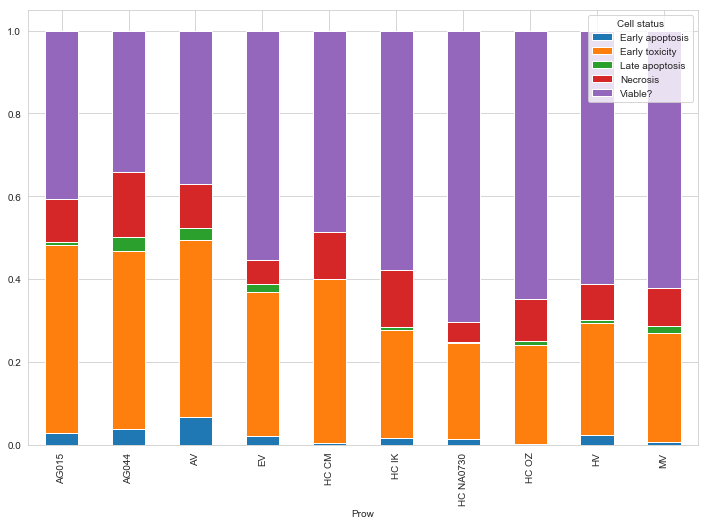

In [20]:
tmp=df_cox17[["Cell status", "Prow"]].groupby(["Prow","Cell status"])["Cell status"].count()/ df_cox17[["Prow"]].groupby("Prow")["Prow"].count()
tmp.unstack().plot(kind='bar', stacked=True)

In [21]:
df_cox17["Toxicity status"].value_counts()

Viable                        3986
Early toxicity                 558
Necrosis                       202
Late apoptosis                  31
Early apoptosis                 22
Condensed nuc in big cells       8
Artifact                         7
Name: Toxicity status, dtype: int64

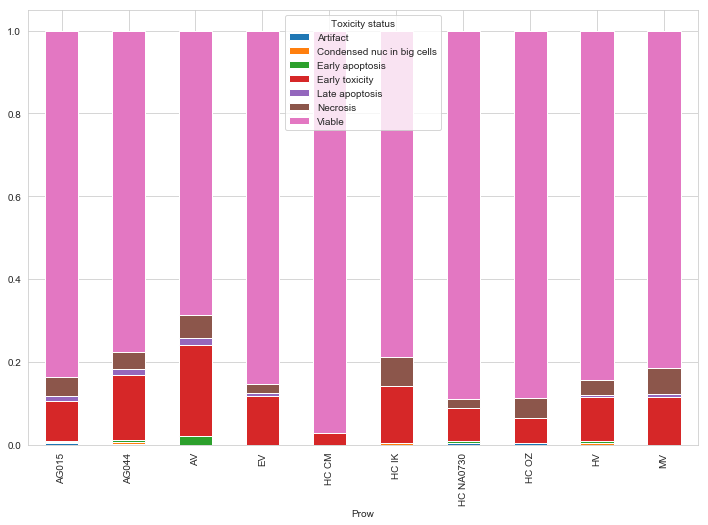

In [22]:
tmp=df_cox17[["Toxicity status", "Prow"]].groupby(["Prow","Toxicity status"])["Toxicity status"].count()/ df_cox17[["Prow"]].groupby("Prow")["Prow"].count()
tmp.unstack().plot(kind='bar', stacked=True)

In [23]:
df_cox17["Cell cycle"].value_counts()

G2M phase      4143
G0/G1 phase     356
S phase         315
Name: Cell cycle, dtype: int64

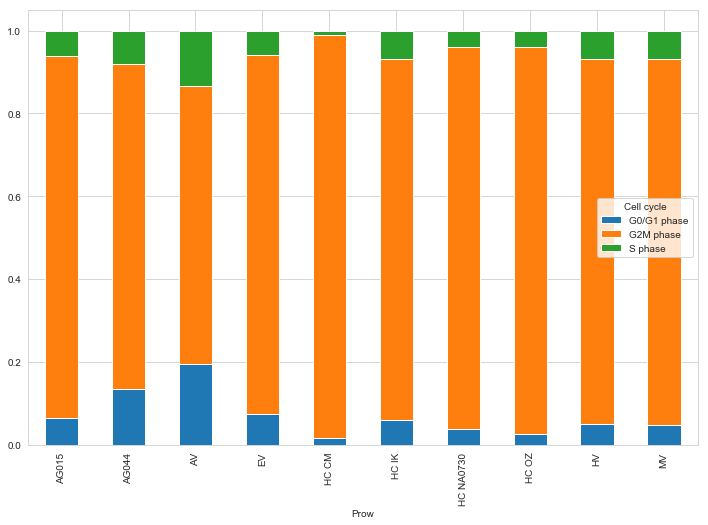

In [24]:
tmp=df_cox17[["Cell cycle", "Prow"]].groupby(["Prow","Cell cycle"])["Cell cycle"].count()/ df_cox17[["Prow"]].groupby("Prow")["Prow"].count()
tmp.unstack().plot(kind='bar', stacked=True)

In [25]:
df_cox17["Prow"].value_counts()

HC IK        574
HC OZ        563
HV           532
AG044        531
AG015        516
EV           494
AV           492
MV           427
HC NA0730    401
HC CM        284
Name: Prow, dtype: int64

## Group by patient


In [26]:
df_cox17["Cox17 total intensity*"] = df_cox17["Cox17 mean area"]*df_cox17["Cox17 mean intensity"]
df_cox17["Cox17 area ratio*"] = df_cox17['Cox17 total area']/df_cox17['Cell area']
df_cox17["Cox17 total intensity ratio*"] = df_cox17["Cox17 total intensity*"]/df_cox17['Cell intensity']

In [27]:
df_grp_row = df_cox17.groupby("Prow")
cox17_features = df_cox17.columns[df_cox17.columns.str.contains("Cox17")].tolist()
cox17_features.remove('Cox17 count')

Cox17 mean intensity  Cox17 mean area  Cox17 total area   Cox17 IxA  Cox17 total intensity*  Cox17 area ratio*  Cox17 total intensity ratio*
Prow                                                                                                                                                   
AG015                  317.0040           1.0605           54.5560  17986.5170              337.606402           0.039387                      0.258299
AG044                  310.5000           0.9250           38.8710  12745.6430              290.362137           0.033666                      0.205986
AV                     327.5145           0.6160           24.3470   7991.5490              204.785676           0.026544                      0.181603
EV                     327.1110           0.6765           42.6205  14043.8465              231.391928           0.026029                      0.206499
HC CM                  327.9450           1.2940           83.7620  28413.6040              422.224312           0.055029                      0.286181
HC IK                  326.2070           1.1310           82.6530  27224.8295              379.069011           0.046873                      0.295155
HC NA0730              336.6710           1.0290          113.8650  39015.1860              358.415475           0.042222                      0.313126
HC OZ                  326.0340           1.1830          124.2170  41332.5270              383.691336           0.051842                      0.308957
HV                     313.7275           1.0490           73.4630  23251.9495              334.645789           0.039719                      0.271122
MV                     333.3050           1.0780           94.1130  32281.0690              360.806498           0.042120                      0.331450

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1804: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018105EE30F0>],
      dtype=object)

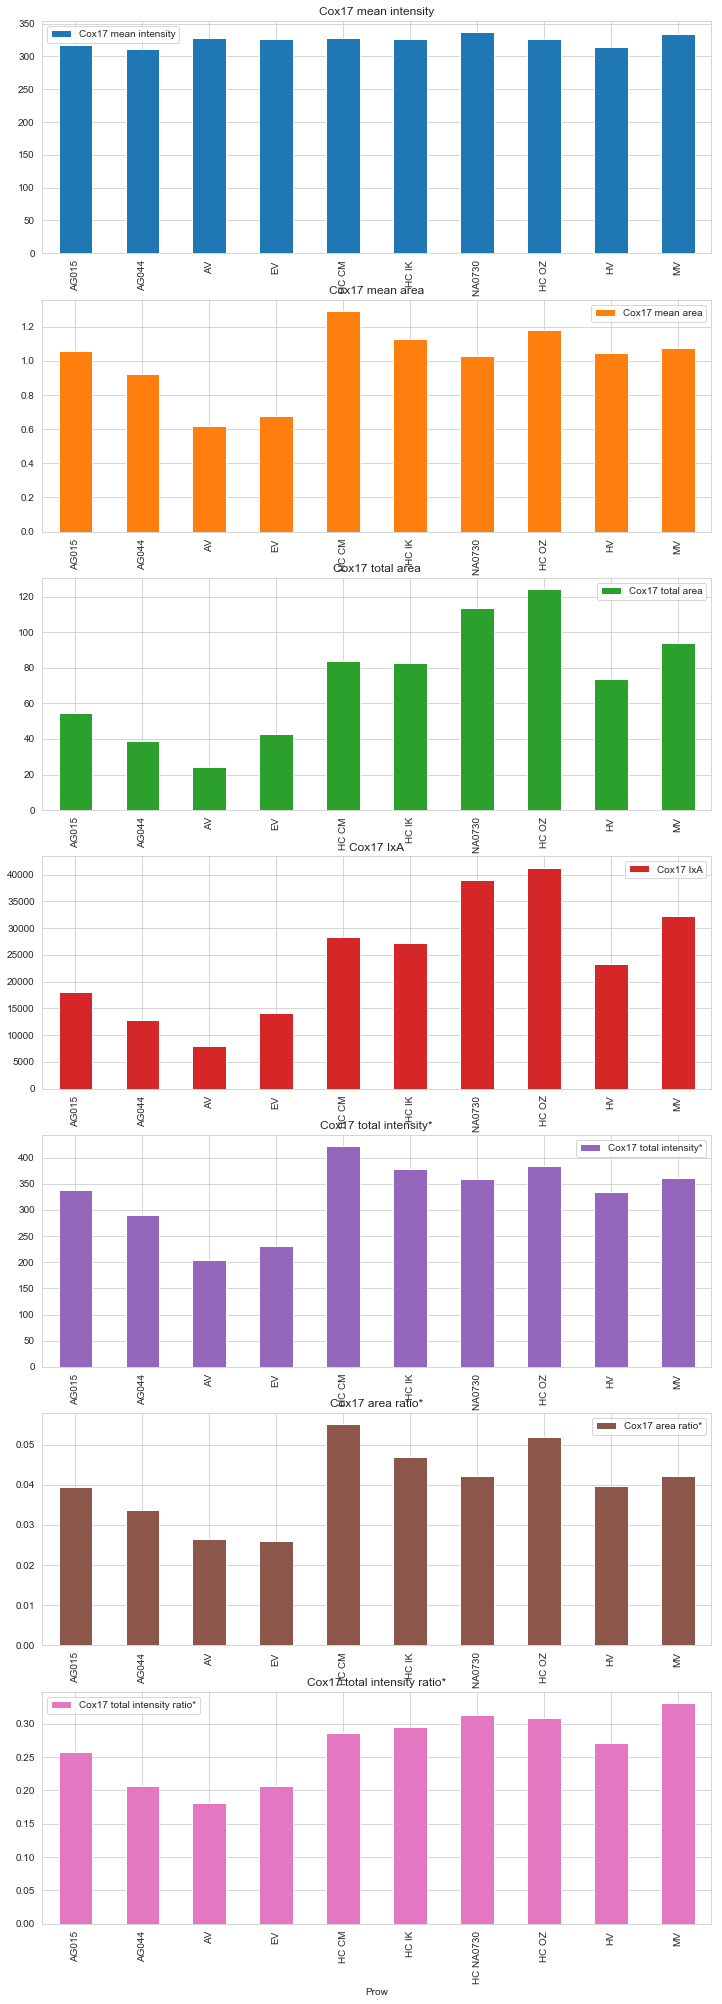

In [28]:
cox17_medians = df_grp_row[cox17_features].median()
display(cox17_medians)


# Create a figure of given size
fig = plt.figure(figsize=(12,5*cox17_medians.shape[1]))
# Add a subplot
ax = fig.add_subplot(111)
# Set title
cox17_medians.plot(kind='bar', ax=ax, subplots=True, layout=(cox17_medians.shape[1],1))

## Cox17 total area
Cox17 total area seems to be correlated with the cell area

Cox17 total area  Cell area
Cox17 total area          1.000000   0.550651
Cell area                 0.550651   1.000000

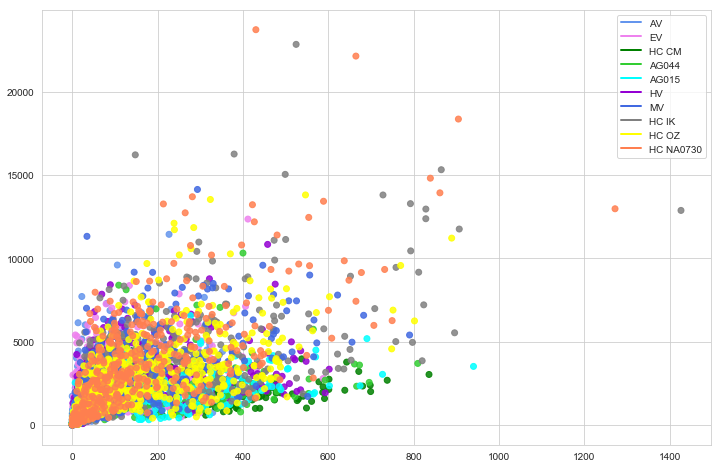

In [29]:
display(df_cox17[["Cox17 total area", "Cell area"]].corr())

from matplotlib.lines import Line2D
lgn = [Line2D([0], [0], color=p['color'], lw=2, label='Line') for p in patients.values()]
plt.scatter(x=df_cox17["Cox17 total area"], y=df_cox17["Cell area"], c=df_cox17["Prow"].apply(lambda x: patients[x]['color']), alpha=0.85)
plt.legend(lgn, patients.keys())

Some correlation exists but it is not strong as the the variance is huge

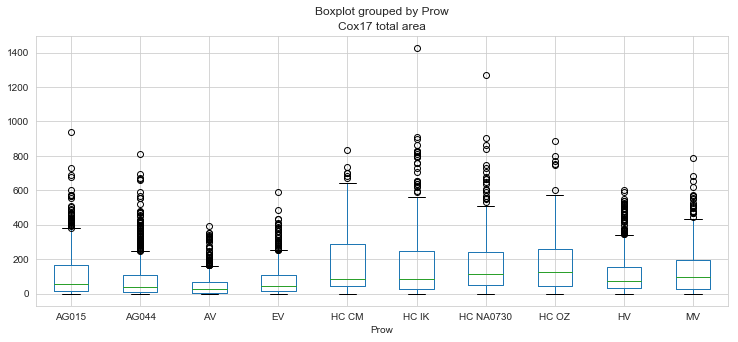

In [30]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 total area",by="Prow", ax=ax)
plt.show()

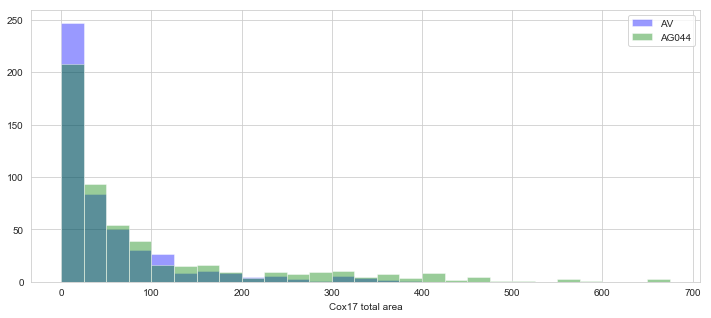

In [31]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_row["Cox17 total area"].get_group('AV'), kde=False, bins=range(0, 700, 25), ax=ax, color='b')
sns.distplot(df_grp_row["Cox17 total area"].get_group('AG044'), kde=False, bins=range(0, 700, 25) ,ax=ax, color='g')
ax.legend(['AV','AG044'])

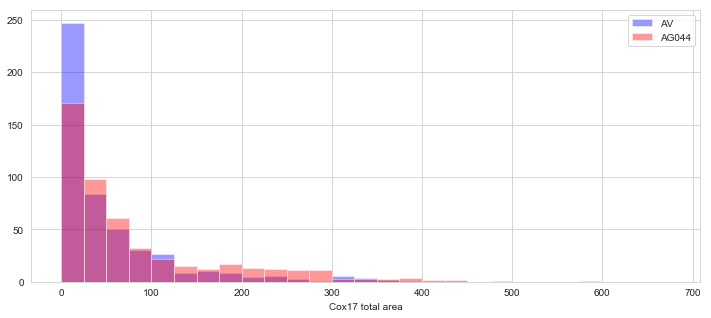

In [32]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_row["Cox17 total area"].get_group('AV'), kde=False,bins=range(0, 700, 25), ax=ax, color='b')
sns.distplot(df_grp_row["Cox17 total area"].get_group('EV'), kde=False, bins=range(0, 700, 25) ,ax=ax, color='r')
ax.legend(['AV','EV'])

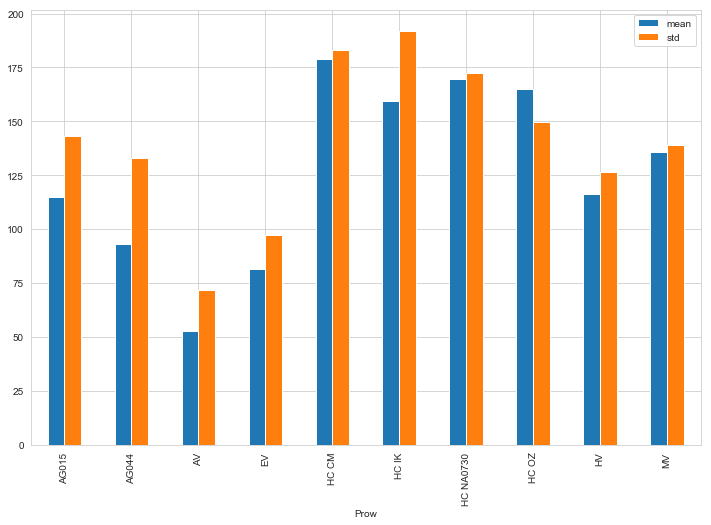

In [33]:
df_grp_row["Cox17 total area"].agg(['mean', 'std']).plot.bar()

The distribution is not Normal (not even symmetric). It look very much like a Poisson distribution but the mean equals the std (and not the variance).  
We will need to do a parametric testing.
To avoid multiple comparison procedures we will focus our effort only on comparing to AV to AG044 and EV. These where chosen as they are the closest to AV and all are children.


In [34]:
from scipy.stats import mannwhitneyu
AV_data = df_grp_row["Cox17 total area"].get_group('AV')
AG044_data = df_grp_row["Cox17 total area"].get_group('AG044')

stat, p = mannwhitneyu(AV_data, AG044_data, alternative="less")
print(f'Statistics={stat:.3f}, p={p:.6f}')

Statistics=109812.500, p=0.000005


In [35]:
AV_data = df_grp_row["Cox17 total area"].get_group('AV')
EV_data = df_grp_row["Cox17 total area"].get_group('EV')

stat, p = mannwhitneyu(AV_data, AG044_data, alternative="less")
print(f'Statistics={stat:.3f}, p={p:.6f}')

Statistics=109812.500, p=0.000005


In [36]:
AV_data = df_grp_row["Cox17 total area"].get_group('AG044')
EV_data = df_grp_row["Cox17 total area"].get_group('EV')

stat, p = mannwhitneyu(AV_data, AG044_data, alternative="less")
print(f'Statistics={stat:.3f}, p={p:.5f}')

Statistics=140980.500, p=0.50004


## Cox 17 - Cell area

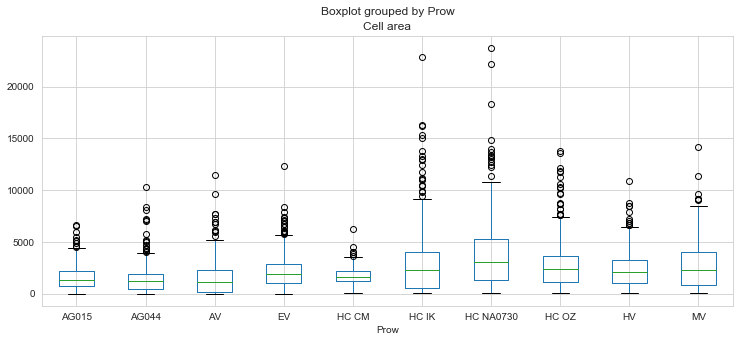

In [37]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cell area",by="Prow", ax=ax)
plt.show()

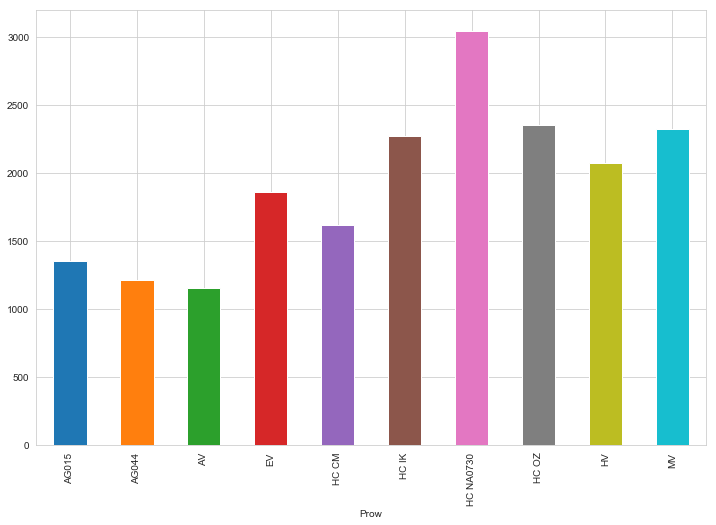

In [38]:
df_grp_row["Cell area"].median().plot(kind='bar')

In [39]:
AV_data = df_grp_row["Cell area"].get_group('AV')
AG044_data = df_grp_row["Cell area"].get_group('AG044')

stat, p = mannwhitneyu(AV_data, AG044_data, alternative="less")
print(f'Statistics={stat:.3f}, p={p:.5f}')

Statistics=129477.500, p=0.40395


# Cox17 area ratio*

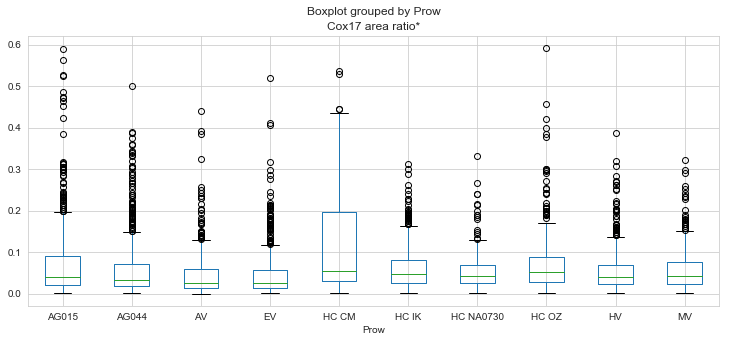

In [40]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 area ratio*",by="Prow", ax=ax)
plt.show()

Prow
AG015        0.039387
AG044        0.033666
AV           0.026544
EV           0.026029
HC CM        0.055029
HC IK        0.046873
HC NA0730    0.042222
HC OZ        0.051842
HV           0.039719
MV           0.042120
Name: Cox17 area ratio*, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018108154400>]],
      dtype=object)

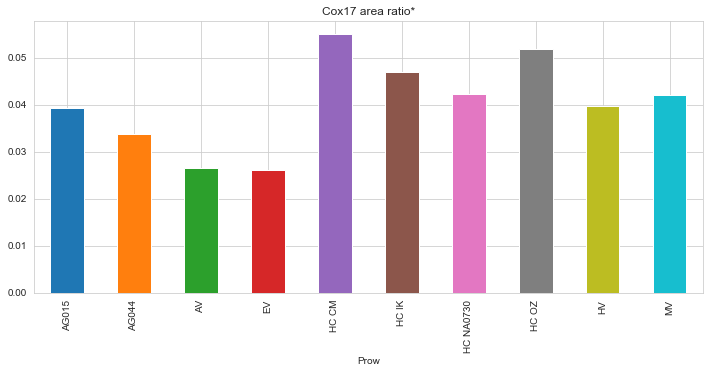

In [41]:
cox17_medians = df_grp_row["Cox17 area ratio*"].median()
display(cox17_medians)


# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)
# Set title
cox17_medians.plot(kind='bar', ax=ax, subplots=True, layout=(1,1))

In [1]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_row["Cox17 area ratio*"].get_group('AV'), kde=True, ax=ax, color='b')
sns.distplot(df_grp_row["Cox17 area ratio*"].get_group('EV'), kde=True ,ax=ax, color='r')
ax.legend(['AV','EV'])

NameError: name 'plt' is not defined

In [43]:
AV_data = df_grp_row["Cox17 area ratio*"].get_group('AV')
AG044_data = df_grp_row["Cox17 area ratio*"].get_group('AG044')

stat, p = mannwhitneyu(AV_data, AG044_data, alternative="less")
print(f'Statistics={stat:.3f}, p={p:.5f}')

Statistics=113610.500, p=0.00016


In [44]:
AV_data = df_grp_row["Cox17 area ratio*"].get_group('AV')
AG044_data = df_grp_row["Cox17 area ratio*"].get_group('EV')

stat, p = mannwhitneyu(AV_data, AG044_data, alternative="less")
print(f'Statistics={stat:.3f}, p={p:.5f}')

Statistics=124810.000, p=0.76885


In [45]:
AV_data = df_grp_row["Cox17 area ratio*"].get_group('EV')
AG044_data = df_grp_row["Cox17 area ratio*"].get_group('AG044')

stat, p = mannwhitneyu(AV_data, AG044_data, alternative="less")
print(f'Statistics={stat:.3f}, p={p:.5f}')

Statistics=110725.000, p=0.00001


In [46]:
AV_data = df_grp_row["Cox17 area ratio*"].get_group('AV')
AG044_data = df_grp_row["Cox17 area ratio*"].get_group('AG015')

stat, p = mannwhitneyu(AV_data, AG044_data, alternative="less")
print(f'Statistics={stat:.3f}, p={p:.5f}')

Statistics=101132.000, p=0.00000


In [47]:
AV_data = df_grp_row["Cox17 area ratio*"].get_group('AG044')
AG044_data = df_grp_row["Cox17 area ratio*"].get_group('AG015')

stat, p = mannwhitneyu(AV_data, AG044_data, alternative="less")
print(f'Statistics={stat:.3f}, p={p:.5f}')

Statistics=126942.000, p=0.01991


# GFER

## Loading data

In [48]:
data_path = ".\\Data\\20181120\\GFER.xls"

In [49]:
df_gfer = pd.read_excel(data_path, header=1)

df_gfer.drop("Target Set",axis=1, inplace=True)
df_gfer.columns = df_gfer.columns.str.replace("Mitochondrial", "GFER")
loc_df = df_gfer.Section.str.extract("(.*) - (.*) \(fld (.*)\).*",expand=True)
loc_df.columns=["Pcol","Prow", "Pfield"]
loc_df.Prow = loc_df.Prow.astype(np.int16)
df_gfer = df_gfer.join(loc_df)
df_gfer.drop("Section",axis=1, inplace=True)
df_gfer.Prow.replace([2,3,4,5,6,7,8,9,10,11], 
                ["AV", "HC CM", "EV", "AG044", "HV", "AG015", "HC IK", "MV", "HC OZ", "HC NA0730"],
               inplace=True)
df_gfer.sample(7)

Target  Nuclear intensity  Nuclear area  Nuclear 1/form factor  Nuclear perimeter  Nuclear IxA Cell cycle Toxicity status  Cell area  Cell length  Cell perimeter  Cell 1/form factor  Cell intensity     Cell IxA     Cell status  GFER count  GFER mean intensity  GFER mean area  GFER total area    GFER IxA  PI intensity  PI intensity/background Pcol   Prow Pfield
1885      47           2968.892       160.130                  1.334             51.810   475408.462  G2M phase          Viable   1131.683       85.476         249.632               4.382        3181.210  3600122.105  Early toxicity          91              353.095           2.371          215.795   76196.166      4077.115                    0.974    B  AG044     17
2411       8           2392.329       193.085                  1.263             55.352   461923.855  G2M phase          Viable   3205.239      137.439         633.440               9.962        2850.861  9137690.433         Viable?         174              329.186           2.008          349.413  115021.752      4329.482                    0.922    B  AG015      6
1703      11           2191.300       209.035                  1.154             55.056   458058.450  G2M phase  Early toxicity    286.882       30.903          81.697               1.851        5005.641  1436027.427  Early toxicity           5              349.156           0.951            4.753    1659.605      3979.726                    0.926    B  AG044     13
4500      16           2749.600       178.826                  1.035             48.230   491699.461  G2M phase          Viable   3086.937      125.364         366.493               3.463        1896.728  5855078.672         Viable?         110              377.135           1.077          118.513   44695.361      3184.422                    0.836    B  HC OZ     12
1895       7           2301.832       124.851                  1.243             44.153   287385.114  G2M phase          Viable   1204.988      108.568         366.546               8.873        2666.245  3212793.645        Necrosis          36              343.383           0.628           22.604    7761.864      6464.003                    1.017    B  AG044     18
1308       8           2087.036       198.578                  1.559             62.366   414439.318  G2M phase          Viable   1707.454       71.153         291.616               3.963        2617.020  4468440.546         Viable?          62              412.964           0.424           26.301   10861.370      3639.426                    0.947    B     EV     20
3619      17           2055.649       232.378                  1.085             56.287   477688.517  G2M phase          Viable   3107.640      133.957         608.766               9.490        2431.327  7555689.285         Viable?         162              353.649           1.501          243.152   85990.602      3988.877                    0.991    B     MV      3

In [50]:
df_gfer.describe()

Target  Nuclear intensity  Nuclear area  Nuclear 1/form factor  Nuclear perimeter   Nuclear IxA     Cell area  Cell length  Cell perimeter  Cell 1/form factor  Cell intensity      Cell IxA   GFER count  GFER mean intensity  GFER mean area  GFER total area      GFER IxA  PI intensity  PI intensity/background
count  5275.000000        5275.000000   5275.000000            5275.000000        5275.000000  5.275000e+03   5275.000000  5275.000000     5275.000000         5275.000000     5275.000000  5.275000e+03  5275.000000          5275.000000     5275.000000      5275.000000  5.275000e+03   5275.000000              5275.000000
mean     16.051754        2447.640614    177.000874               1.230917          49.189590  4.709506e+05   2380.511476   110.608008      406.602825            6.407840     3050.502802  5.927459e+06    69.324739           437.493096        2.615457       130.238319  5.424670e+04   4098.359139                 0.958927
std      10.942422         801.255061    336.994045               0.255123          19.753069  2.766338e+06   2139.541699    64.135244      284.817598            4.867843     1325.807990  4.584395e+06    64.112285           678.975369        7.832243       166.306016  1.478639e+05   1678.543677                 0.198696
min       1.000000        1012.000000      0.106000               0.637000           0.919000  1.068940e+02      0.528000     1.379000        3.329000            1.057000     1148.620000  2.431207e+03     1.000000           228.000000        0.106000         0.106000  2.408300e+01   1238.333000                 0.328000
25%       7.000000        2014.354500    124.269500               1.088000          44.721500  2.742971e+05    972.504000    62.997000      206.982500            3.014500     2155.028500  3.012287e+06    23.000000           329.378500        0.486000        15.844000  5.710385e+03   3042.539000                 0.841000
50%      14.000000        2293.901000    183.156000               1.156000          51.537000  4.625702e+05   1893.673000   106.364000      363.585000            5.146000     2756.247000  5.274747e+06    53.000000           346.468000        0.763000        55.243000  2.043462e+04   3774.979000                 0.954000
75%      23.000000        2699.159500    214.739000               1.288000          55.607500  5.125047e+05   3143.130000   149.317500      543.592000            8.284000     3575.346500  7.774623e+06    96.000000           370.530500        2.258500       205.919000  7.555158e+04   4763.933500                 1.051000
max      59.000000       22045.578000  17209.106000               7.533000         791.637000  1.945800e+08  24252.075000   445.287000     3035.981000           46.174000    32416.441000  1.259600e+08   779.000000         17828.506000      203.542000      1459.548000  6.862044e+06  22425.246000                 4.165000

In [51]:
df_gfer["Cell status"].value_counts()

Viable?            2969
Early toxicity     1670
Necrosis            540
Early apoptosis      62
Late apoptosis       34
Name: Cell status, dtype: int64

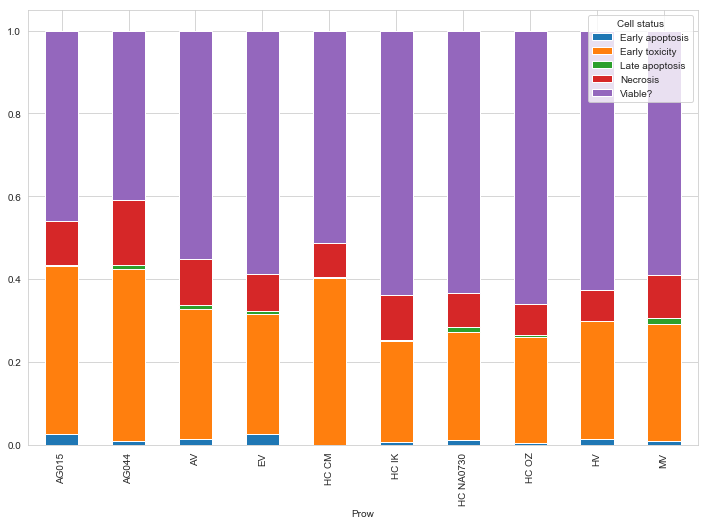

In [52]:
tmp=df_gfer[["Cell status", "Prow"]].groupby(["Prow","Cell status"])["Cell status"].count()/df_gfer[["Prow"]].groupby("Prow")["Prow"].count()
tmp.unstack().plot(kind='bar', stacked=True)

In [53]:
df_gfer["Toxicity status"].value_counts()

Viable                        4551
Early toxicity                 490
Necrosis                       182
Early apoptosis                 19
Late apoptosis                  16
Artifact                        12
Condensed nuc in big cells       5
Name: Toxicity status, dtype: int64

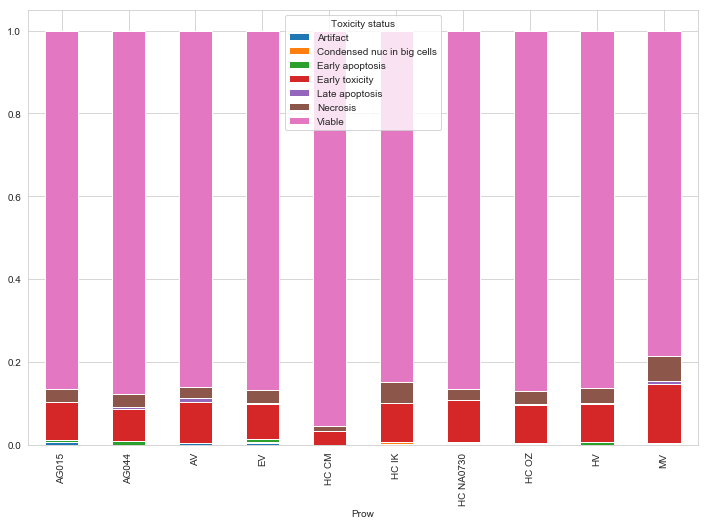

In [54]:
tmp=df_gfer[["Toxicity status", "Prow"]].groupby(["Prow","Toxicity status"])["Toxicity status"].count()/ df_gfer[["Prow"]].groupby("Prow")["Prow"].count()
tmp.unstack().plot(kind='bar', stacked=True)

In [55]:
df_gfer["Cell cycle"].value_counts()

G2M phase      4811
S phase         249
G0/G1 phase     215
Name: Cell cycle, dtype: int64

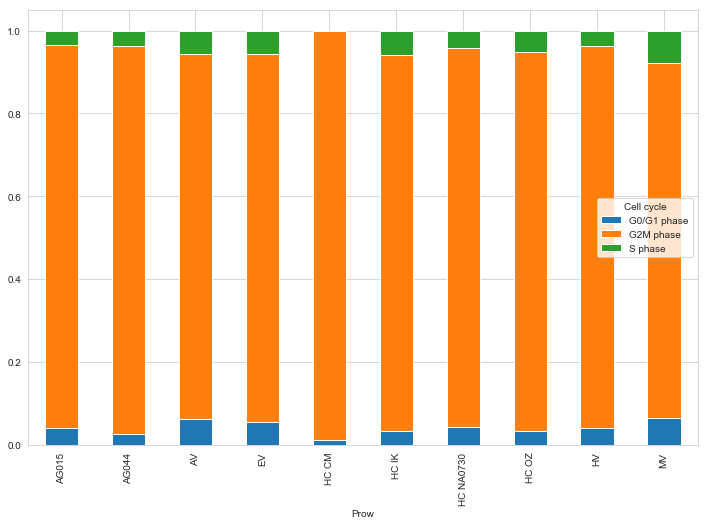

In [56]:
tmp=df_gfer[["Cell cycle", "Prow"]].groupby(["Prow","Cell cycle"])["Cell cycle"].count()/df_gfer[["Prow"]].groupby("Prow")["Prow"].count()
tmp.unstack().plot(kind='bar', stacked=True)

## Group by patient

In [57]:
df_gfer["GFER total intensity*"] = df_gfer["GFER mean area"]*df_gfer["GFER mean intensity"]
df_gfer["GFER area ratio*"] = df_gfer['GFER total area']/df_gfer['Cell area']
df_gfer["GFER total intensity ratio*"] = df_gfer["GFER total intensity*"]/df_gfer['Cell intensity']

In [58]:
df_grp_gfer_row = df_gfer.groupby("Prow")
GFER_features = df_gfer.columns[df_gfer.columns.str.contains("GFER")].tolist()
GFER_features.remove('GFER count')

GFER mean intensity  GFER mean area  GFER total area    GFER IxA  GFER total intensity*  GFER area ratio*  GFER total intensity ratio*
Prow                                                                                                                                             
AG015                 344.4790          0.8600           43.835  19180.6260             361.574500          0.031892                     0.118215
AG044                 362.6600          0.8260           55.982  20522.8230             307.941945          0.036004                     0.094035
AV                    351.7680          0.6980           51.018  18482.2230             277.547010          0.027415                     0.093701
EV                    344.9415          0.6175           33.272  12194.7475             220.718388          0.024099                     0.095228
HC CM                 342.9180          1.6800          133.829  47948.2370             650.409945          0.071653                     0.190731
HC IK                 338.4840          0.7780           65.066  24114.9720             280.285560          0.031087                     0.111619
HC NA0730             366.2770          0.8475           82.811  32122.5235             339.985944          0.033836                     0.148979
HC OZ                 338.7085          0.6890           51.704  18348.0245             247.535561          0.024608                     0.108021
HV                    332.6310          0.7020           49.116  17252.3070             236.832096          0.026296                     0.091474
MV                    341.3570          0.5370           37.497  13606.7110             191.246821          0.022049                     0.092942

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1804: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018107DA5D30>],
      dtype=object)

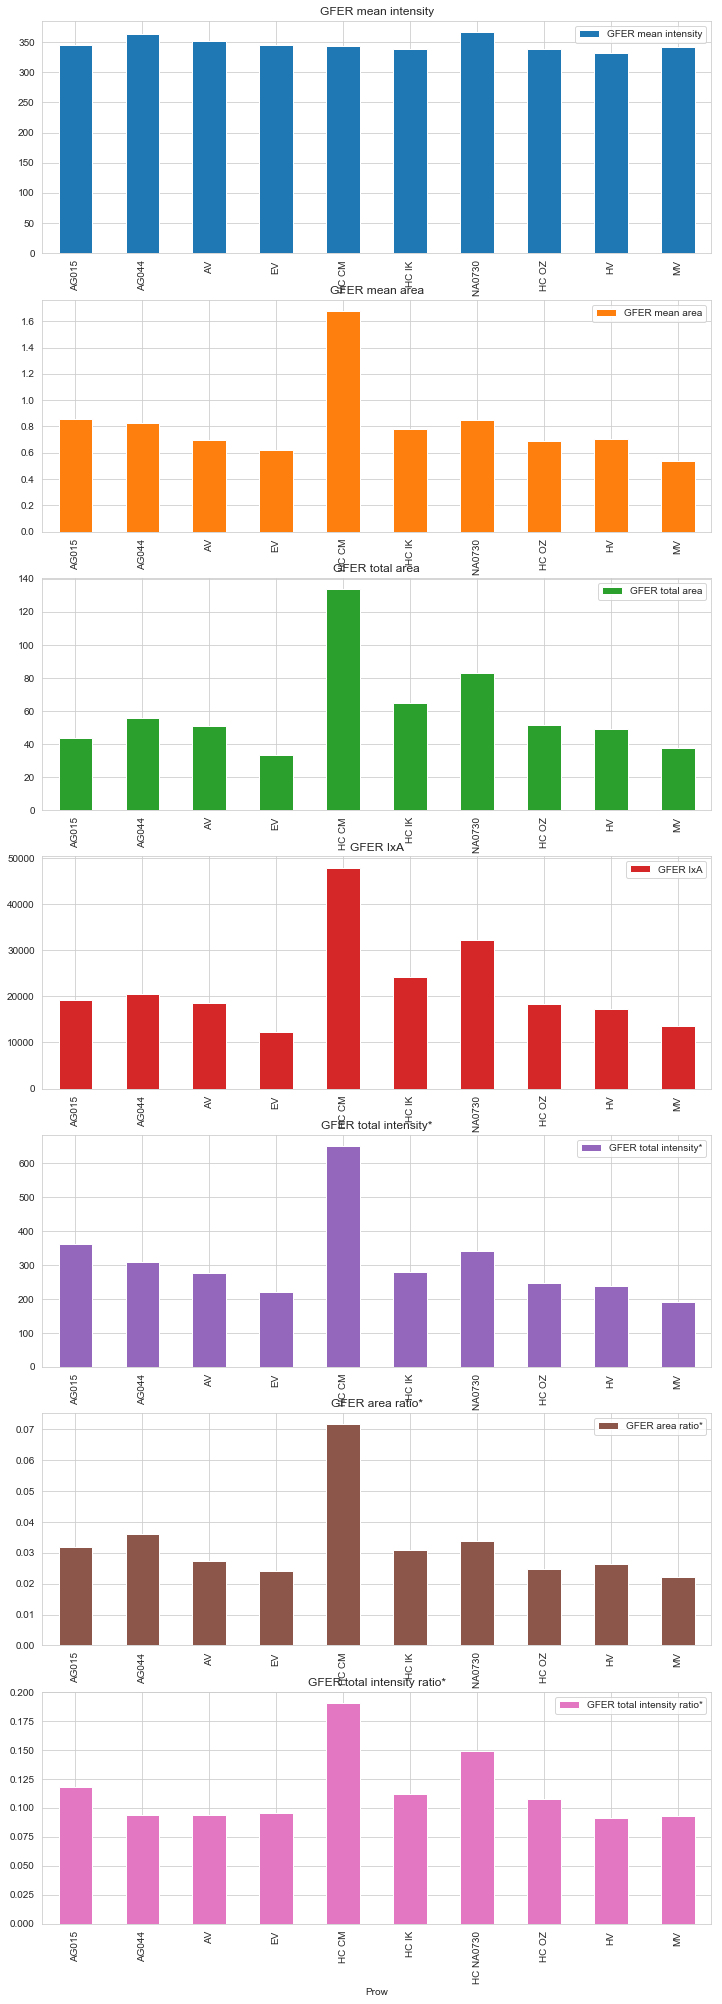

In [59]:
GFER_medians = df_grp_gfer_row[GFER_features].median()
display(GFER_medians)


# Create a figure of given size
fig = plt.figure(figsize=(12,5*GFER_medians.shape[1]))
# Add a subplot
ax = fig.add_subplot(111)
# Set title
GFER_medians.plot(kind='bar', ax=ax, subplots=True, layout=(GFER_medians.shape[1],1))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


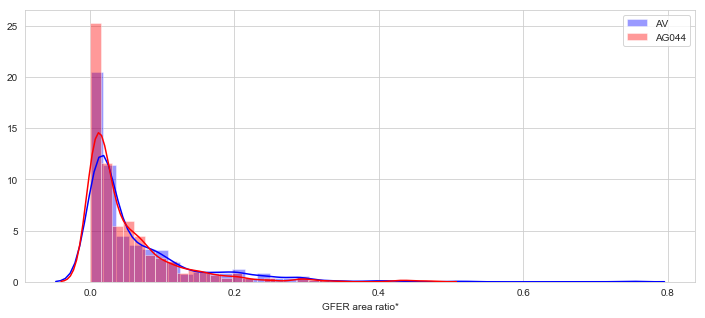

In [60]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_gfer_row["GFER area ratio*"].get_group('AV'), kde=True, ax=ax, color='b')
sns.distplot(df_grp_gfer_row["GFER area ratio*"].get_group('EV'), kde=True ,ax=ax, color='r')
ax.legend(['AV','AG044'])

In [61]:
AV_data = df_grp_gfer_row["GFER area ratio*"].get_group('AV')
AG044_data = df_grp_gfer_row["GFER area ratio*"].get_group('AG044')

stat, p = mannwhitneyu(AV_data, AG044_data, alternative="less")
print(f'Statistics={stat:.3f}, p={p:.5f}')

Statistics=150724.000, p=0.00036


In [62]:
AV_data = df_grp_gfer_row["GFER area ratio*"].get_group('AV')
AG044_data = df_grp_gfer_row["GFER area ratio*"].get_group('EV')

stat, p = mannwhitneyu(AV_data, AG044_data, alternative="less")
print(f'Statistics={stat:.3f}, p={p:.5f}')

Statistics=116067.000, p=0.99671


# Comparing rows

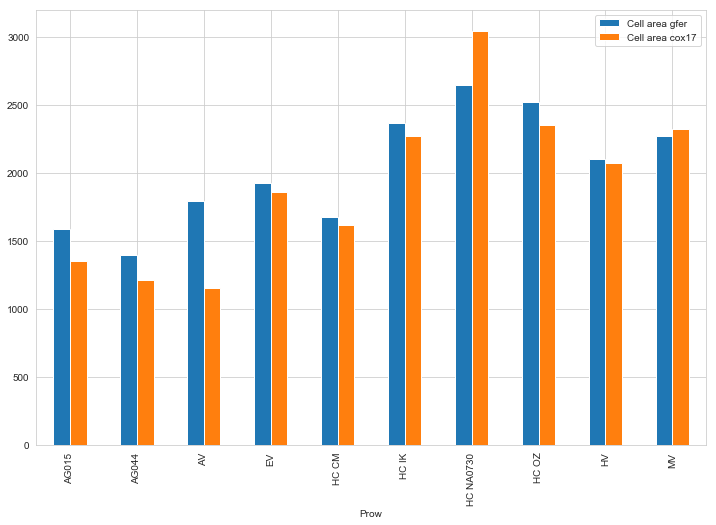

In [63]:
unified_df = pd.DataFrame()
unified_df["Cell area gfer"]=df_gfer.groupby("Prow")["Cell area"].median()
unified_df["Cell area cox17"]=df_cox17.groupby("Prow")["Cell area"].median()
unified_df.plot(kind='bar')